In [2]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from kan import KAN
from fucntions import data_seq,train_seq
from sklearn.preprocessing import MinMaxScaler

In [3]:
"""
!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git
%cd QHackathon_2024/
!pip install -r requirements.txt"""

'\n!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git\n%cd QHackathon_2024/\n!pip install -r requirements.txt'

### Functions

In [4]:
n_qu = 4
dev = qml.device('default.qubit', wires=n_qu)

In [5]:
def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([n_qu - 1, 0])

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[:,i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])

# def embedding(params, n_qu, is_first):
#     for i in range(n_qu):
#         qml.Hadamard(wires=i if is_first else i+n_qu)
#         qml.RZ(2.0*params[:,i], wires=i if is_first else i+n_qu)

#     for i in range(n_qu-1):
#         qml.IsingZZ(2.0*params[:, i] ,wires = [i if is_first else i+n_qu, i+1 if is_first else i+n_qu+1])

@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()

@qml.qnode(device=dev, interface='torch')
def quantum_layer_Z(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu = n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu)]

@qml.qnode(device=dev, interface='torch')
def quantum_layer_prob(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu=n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval((qml.PauliZ(i)+qml.Identity(i))/2) for i in range(n_qu)]


(<Figure size 2800x500 with 1 Axes>, <Axes: >)

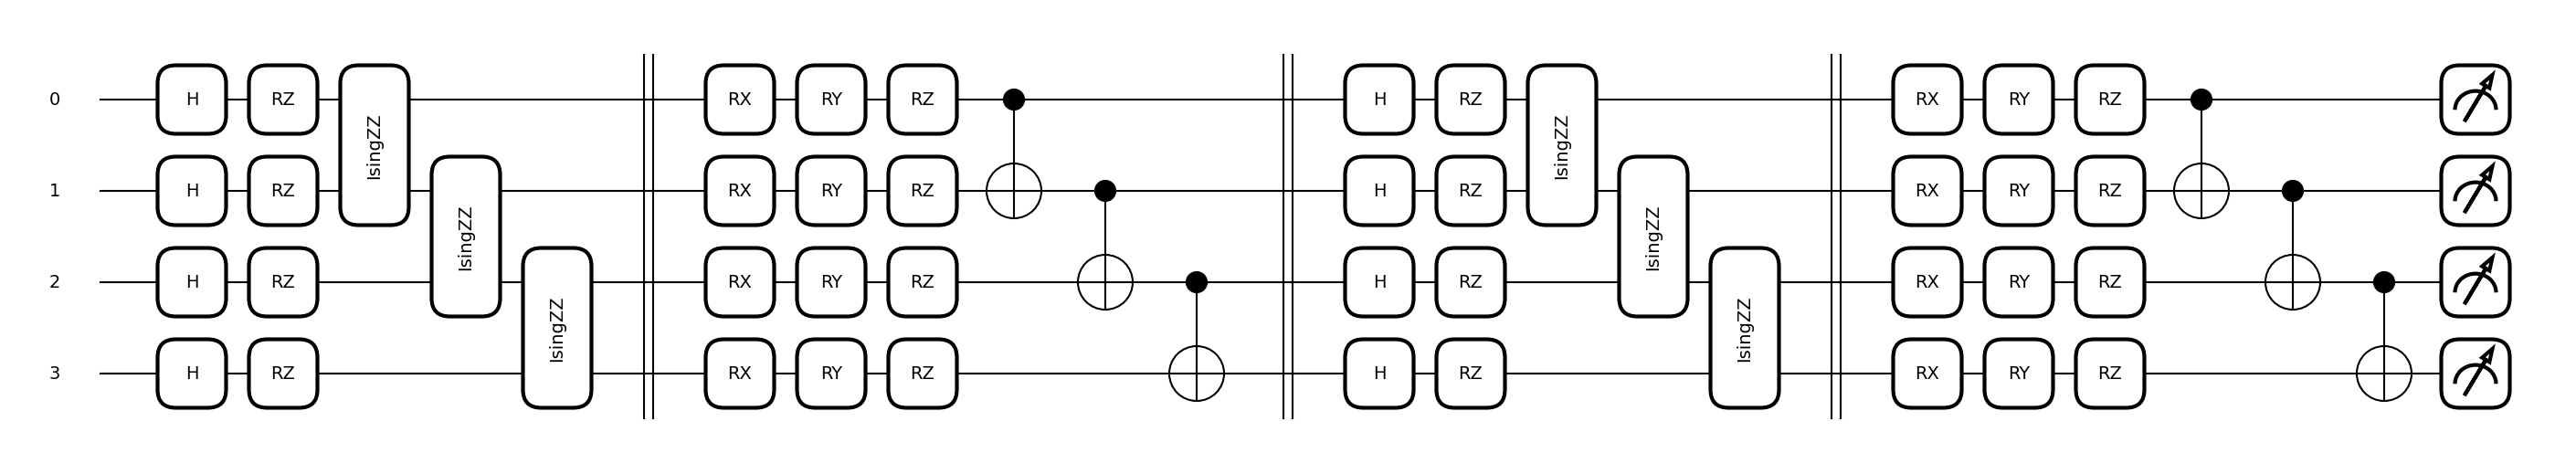

In [6]:
qml.draw_mpl(quantum_layer_prob)(mapped_data1 = torch.rand(1,2*n_qu-1), parameter1 = torch.rand(1,3*n_qu), mapped_data2 = torch.rand(1,2*n_qu-1), parameter2 = torch.rand(1,3*n_qu), n_qu=n_qu)

### NQE Class

In [7]:
class NQE(nn.Module):
    def __init__(self, n_feature, mode : str):
        '''
            Args:
                type(str) : 'FC' or 'KAN'
                n_feature(int) : # of feature
        '''
        super(NQE, self).__init__()

        self.mode = mode

        if mode == 'FC':
            self.li1 = nn.Linear(n_feature, 16)
            self.li2 = nn.Linear(16, 16)
            self.li3 = nn.Linear(16, 2 * n_feature - 1)
        
        if mode == 'KAN':
            self.n_qu = n_feature
            self.linear1 = KAN([self.n_qu, self.n_qu * 2 + 1, self.n_qu * 2 - 1], grid = 1)
            self.quantum_layer = fidelity

    def forward_FC(self, inputs):
        inputs = self.li1(inputs)
        inputs = F.relu(inputs)
        inputs = self.li2(inputs)
        inputs = F.relu(inputs)
        inputs = self.li3(inputs)
        inputs = 2 * torch.pi * F.relu(inputs)
        ## Quantum Layer 추가 필요
        return inputs # Quantum Layer의 output을 리턴

    def forwad_KAN(self, inputs):
        input1 = inputs[0]
        input2 = inputs[1]
        input1 = self.linear1(input1)
        input2 = self.linear1(input2)
        output = self.quantum_layer(input1, input2, self.n_qu)[ : , 0]
        return output

    def forward(self, inputs):
        if self.mode == 'FC':
            return self.forward_FC(inputs)
        if self.mode == 'KAN':
            return self.forwad_KAN(inputs)
    

#### NQE Train

In [8]:
df = pd.read_csv('./dataset.csv')

In [9]:
nqe_train = 250

nqe_y_train = torch.tensor(df['nat_demand'].to_numpy()[:nqe_train]).to(torch.float)
nqe_x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:nqe_train]).to(torch.float)

nqe_xs_train = torch.tensor([(nqe_x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T
print(nqe_xs_train[1])
nqe_y_train = (nqe_y_train-nqe_y_train.min())/(nqe_y_train.max()-nqe_y_train.min())


tensor([1.7476e-02, 2.3959e+01, 3.5131e-02, 1.2807e+01])


In [10]:
nqe_train_list = []
nqe_train_label_list = []
nqe_test_list = []
nqe_test_label_list = []

for i in range(nqe_train-1):
    nqe_train_data = torch.stack([nqe_xs_train, torch.concat([nqe_xs_train[( i + 1 ) : ],nqe_xs_train[:(i+1)]])])
    nqe_train_list.append(nqe_train_data)
    nqe_label_data = torch.stack([nqe_y_train,torch.concat([nqe_y_train[(i+1):],nqe_y_train[:(i+1)]])])
    nqe_train_label_list.append(nqe_label_data)

In [11]:
nqe_train_data = torch.concat(nqe_train_list, dim = 1)
nqe_train_label = torch.concat(nqe_train_label_list, dim = 1)

In [85]:
nqe_train_data.shape

torch.Size([2, 62250, 4])

In [52]:
from torch import optim
pretrain_data = data_seq(nqe_train_data, nqe_train_label)
nqe_train_loader, nqe_test_loader = pretrain_data.split_data(batch_size = 64, seq_first = True)
my_nqe = NQE(n_qu, 'KAN')
optimizer = optim.Adam(my_nqe.parameters(),lr = 0.005)

def criterion(pred, label):
    return -torch.sum(torch.log(1-pred)*(label[:,0]-label[:,1])**2 + torch.log(pred)*(1-(label[:,0]-label[:,1])**2))/len(pred)

In [53]:
pretrain_seq = train_seq(my_nqe, nqe_train_loader, nqe_test_loader)
pretrain_seq.train(3, optimizer, criterion, seq_first = True)

epoch : 1 loss :1.4440494775772095 loss_test = 1.0492675304412842
epoch : 2 loss :1.0303434133529663 loss_test = 1.0218679904937744
epoch : 3 loss :1.0075324773788452 loss_test = 0.9937018156051636


([1.4440494775772095, 1.0303434133529663, 1.0075324773788452],
 [1.0492675304412842, 1.0218679904937744, 0.9937018156051636])

In [54]:
pretrain_seq.train(5, optimizer, criterion, seq_first = True)

epoch : 1 loss :0.9079919457435608 loss_test = 0.8435789942741394
epoch : 2 loss :0.6604340672492981 loss_test = 0.5227009057998657
epoch : 3 loss :0.3792859613895416 loss_test = 0.36090975999832153
epoch : 4 loss :0.36124271154403687 loss_test = 0.3644709289073944
epoch : 5 loss :0.3618600070476532 loss_test = 0.35899877548217773


([0.9079919457435608,
  0.6604340672492981,
  0.3792859613895416,
  0.36124271154403687,
  0.3618600070476532],
 [0.8435789942741394,
  0.5227009057998657,
  0.36090975999832153,
  0.3644709289073944,
  0.35899877548217773])

In [55]:
pretrain_seq.train(3, optimizer, criterion, seq_first = True)

epoch : 1 loss :0.36128464341163635 loss_test = 0.3673866093158722
epoch : 2 loss :0.36075925827026367 loss_test = 0.3691498935222626
epoch : 3 loss :0.3596438765525818 loss_test = 0.3624372184276581


([0.36128464341163635, 0.36075925827026367, 0.3596438765525818],
 [0.3673866093158722, 0.3691498935222626, 0.3624372184276581])

### GRU Class

In [38]:
class QGRU(nn.Module):
    def __init__(self, n_qu, nqe_model = None):
        self.n_qu = n_qu
        super(QGRU, self).__init__()
        for i in range(2):
            setattr(self,f'ql{i}', quantum_layer_prob)
        self.ql2 = quantum_layer_Z
        self.cls_layer = nn.Sequential(nn.Linear(n_qu,8),nn.Dropout(0.1) ,nn.ReLU(),nn.Linear(8,1)).to(torch.float32)

        self.nqe_model = nqe_model

        self.ansatz_params_11 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_12 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_21 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_22 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_31 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_32 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.KAN_layer = KAN([4,3,7],grid=1)

    def nQE_layer(self, input, nqe_model=None):
        if nqe_model == None:
            n_qu = input.shape[1]
            n_batch = input.shape[0]
            for i in range(n_qu-1):
                input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
            return input
        
        if nqe_model.mode == 'KAN':
            result = self.nqe_model.linear1(input)
            
        
        if nqe_model.mode == 'FC':
            pass
            # result = self.nqe_model.

            # self.li1 = nn.Linear(n_feature, 16)
            # self.li2 = nn.Linear(16, 16)
            # self.li3 = nn.Linear(16, 2 * n_feature - 1)
        return result

    
    
    
    def forward(self, inputs, return_hidden_list = False):
        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        n_qu = inputs.shape[2]
        inputs = inputs.permute(1,0,2)
        h0 = torch.zeros(batch,n_qu)
        input0 = self.KAN_layer(inputs[0])
        r0 = torch.stack(self.ql0(mapped_data1 = input0, mapped_data2 = self.nQE_layer(h0), parameter1 = self.ansatz_params_11, parameter2 = self.ansatz_params_12, n_qu = n_qu),dim=1)
        z0 = torch.stack(self.ql1(mapped_data1 = input0, mapped_data2 = self.nQE_layer(h0), parameter1 = self.ansatz_params_21, parameter2 = self.ansatz_params_22, n_qu = n_qu),dim=1)
        n0 = torch.stack(self.ql2(mapped_data1 = input0, mapped_data2 = self.nQE_layer(r0), parameter1 = self.ansatz_params_31, parameter2 = self.ansatz_params_32, n_qu = n_qu),dim=1)
        hidden = (1-z0)*n0+z0*h0
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.KAN_layer(input)
            h = hidden
            ah = self.nQE_layer(hidden)
            r = torch.stack(self.ql0(mapped_data1 = input, mapped_data2 = ah, parameter1 = self.ansatz_params_11, parameter2 = self.ansatz_params_12, n_qu = n_qu),dim=1)
            z = torch.stack(self.ql1(mapped_data1 = input, mapped_data2 = ah, parameter1 = self.ansatz_params_21, parameter2 = self.ansatz_params_22, n_qu = n_qu),dim=1)
            n = torch.stack(self.ql2(mapped_data1 = input, mapped_data2 = self.nQE_layer(r), parameter1 = self.ansatz_params_31, parameter2 = self.ansatz_params_32, n_qu = n_qu),dim=1)
            hidden = (1-z)*n+z*h
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list, hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch, seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden.to(torch.float32))

#### GRU Train

In [39]:
import pandas as pd

n_train = 1000
df = pd.read_csv('./dataset.csv')
print(df.keys())

Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')


In [40]:
scaler = MinMaxScaler(feature_range = (0, 6.28))
temp_data = scaler.fit_transform(df[df.keys()[1:]])
y_train = torch.tensor(df['nat_demand'].to_numpy()[[5+5*i for i in range(50)]])

In [41]:
y_train = torch.tensor(temp_data[:,0][[5+5*i for i in range(50)]])
y_train = torch.unsqueeze(y_train,dim=1)
print(y_train.shape)
x_train = torch.tensor(temp_data[:,:4][:250]).to(torch.float)
x_train = torch.reshape(x_train,[-1,5,4])


x_train = torch.tensor(x_train)
xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(-1,5,4)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


torch.Size([50, 1])


C:\Users\pop75\AppData\Local\Temp\ipykernel_22920\1273997657.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train)


In [45]:
import torch.optim as optim
GRU_model = QGRU(4).to(torch.float32)

criterion = nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.002)

In [46]:
#data_corpus = data_seq(x_train.float(),y_train.float())
#train_loader,test_loader = data_corpus.split_data()
import pickle
with open('train_data.pkl','rb') as file:
    #pickle.dump(data_dict ,file)
    data_dict = pickle.load(file)

train_loader,test_loader = data_dict['train'],data_dict['test']
train_corpus = train_seq(GRU_model, train_loader, test_loader)

In [47]:
train_loss_list, test_loss_list = train_corpus.train(200, optimizer, criterion)

epoch : 1 loss :13.966863632202148 loss_test = 14.27221393585205
epoch : 2 loss :13.408897399902344 loss_test = 13.606446266174316
epoch : 3 loss :12.662742614746094 loss_test = 12.873587608337402
epoch : 4 loss :11.816173553466797 loss_test = 11.873527526855469
epoch : 5 loss :10.739849090576172 loss_test = 10.771671295166016
epoch : 6 loss :9.49081039428711 loss_test = 9.494850158691406
epoch : 7 loss :8.101956367492676 loss_test = 7.842398166656494
epoch : 8 loss :6.48605489730835 loss_test = 6.364681243896484
epoch : 9 loss :4.898154258728027 loss_test = 4.717789649963379
epoch : 10 loss :3.5934722423553467 loss_test = 3.396153211593628
epoch : 11 loss :2.544501543045044 loss_test = 2.2324068546295166
epoch : 12 loss :1.8539881706237793 loss_test = 2.0940396785736084
epoch : 13 loss :1.4183650016784668 loss_test = 1.509981632232666
epoch : 14 loss :1.1375422477722168 loss_test = 1.1017283201217651
epoch : 15 loss :1.0428026914596558 loss_test = 0.9685251712799072
epoch : 16 loss :0

### NQE + QRNN Model  (Simultaneous)

In [111]:
from RNN_block import RNN_block
from kan import KAN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0),self.hidden_size)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 사용
        return out

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs1,inputs2, weights1,weights2):
    block = RNN_block(4)
    block.embedding(inputs1)
    block.ansatz(weights1)
    block.embedding(inputs2)
    block.ansatz(weights2)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

def quantum_layer(inputs1,inputs2, weights1,weights2):
    return quantum_circuit(inputs1,inputs2, weights1,weights2)

def generate_tensor(seed, size):
    """
    주어진 시드와 크기에 맞게 torch.Tensor를 생성합니다.

    Args:
        seed (int): 시드 값
        size (tuple): 생성할 텐서의 크기

    Returns:
        torch.Tensor: 생성된 텐서
    """
    torch.manual_seed(seed)
    return torch.randn(size)

class RNN_layer(nn.Module):
    def __init__(self,input_size,output_size,num_layers):
        """_RNN layer 만든거_

        Args:
            input_size (_int_): _input feature의 개수_
            output_size (_int_): _output feature의 개수_
            num_layers (_int_): _필요한 RNN layer 수_
        """
        super(RNN_layer, self).__init__()
        self.linear = KAN([input_size,input_size*2-1],grid=1)
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layers
        self.cls_layer = nn.Sequential(nn.Linear(4,16),nn.ReLU(),nn.Linear(16,1))
        ## QNE 수행할 Linear layer
        setattr(self,'QNE_layer_0',KAN([input_size,2*input_size+1,input_size*2-1],grid=1))

        ## Ansatz parameter
        self.ansatz_params_1 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([24],dtype = torch.float32),requires_grad=True)
        self.rnn_layer = quantum_layer


    def forward(self,inputs,return_hidden_list = False):
        """_summary_

        Args:
            inputs (_torch tensor_): _(batch,seq_len,feature_size)_
        """

        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        initial_t = generate_tensor(30,[inputs.shape[0],inputs.shape[2]*2-1]).float()
        inputs = inputs.permute(1, 0, 2)
        ## inputs  = (seq_len,batch,feature_size)
        input = getattr(self,f'QNE_layer_{0}')(inputs[0])
        
        hidden = torch.stack(self.rnn_layer(initial_t,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
        hidden = hidden.to(torch.float32)
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = getattr(self,f'QNE_layer_{0}')(input)
            hidden = self.linear(hidden)
            hidden = torch.stack(self.rnn_layer(hidden,input,self.ansatz_params_1,self.ansatz_params_2),dim=1).float()
            hidden = hidden.to(torch.float32)
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list,hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch,seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden)

In [112]:
import torch.optim as optim
model = QGRU(4).to(torch.float32)

#model = RNN_layer(4,1,5)
#model = RNNModel(4,32,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [113]:
data_corpus = data_seq(x_train.float(),y_train.float())
train_loader,test_loader = data_corpus.split_data()
train_corpus = train_seq(model, train_loader, test_loader)

In [114]:
train_loss_list, test_loss_list = train_corpus.train(200,optimizer,criterion)

epoch : 1 loss :13.341794967651367 loss_test = 16.514684677124023
epoch : 2 loss :12.699828147888184 loss_test = 15.888689994812012
epoch : 3 loss :12.104558944702148 loss_test = 15.187475204467773
epoch : 4 loss :11.480220794677734 loss_test = 14.846578598022461
epoch : 5 loss :10.963174819946289 loss_test = 14.005541801452637
epoch : 6 loss :10.581181526184082 loss_test = 13.382680892944336
epoch : 7 loss :10.000518798828125 loss_test = 12.939065933227539
epoch : 8 loss :9.540203094482422 loss_test = 11.988208770751953
epoch : 9 loss :9.137885093688965 loss_test = 11.963485717773438
epoch : 10 loss :8.496434211730957 loss_test = 10.763891220092773
epoch : 11 loss :7.897786617279053 loss_test = 9.905102729797363
epoch : 12 loss :7.281687259674072 loss_test = 9.391168594360352
epoch : 13 loss :6.724888801574707 loss_test = 8.589300155639648
epoch : 14 loss :6.097761154174805 loss_test = 8.069601058959961
epoch : 15 loss :5.677614688873291 loss_test = 7.156121730804443
epoch : 16 loss :

KeyboardInterrupt: 

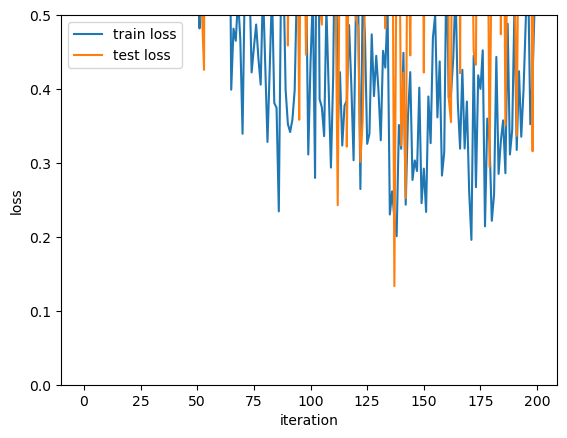

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label = 'train loss')
plt.ylim(0,0.5)
plt.plot(test_loss_list, label = 'test loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend()

In [ ]:
def decoding(input,max_value):
  return (np.max(df['nat_demand'])-np.min(df['nat_demand']))/max_value*input+np.min(df['nat_demand'])

for feature,label in test_loader:
    pred = decoding(model(feature),2*3.14)
    true = decoding(label,2*3.14)
    print(nn.MSELoss()(true,pred))
    break

tensor(52348.4570, grad_fn=<MseLossBackward0>)


In [28]:
def decoding(input,max_value):
  return (np.max(df['nat_demand'])-np.min(df['nat_demand']))/max_value*input+np.min(df['nat_demand'])

for feature,label in test_loader:
    pred = decoding(model(feature),2*3.14)
    true = decoding(label,2*3.14)
    print(nn.MSELoss()(true,pred))
    break

tensor(19328.1973, grad_fn=<MseLossBackward0>)


In [ ]:
y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float).reshape(1,50,1)
print(y_train.shape)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)
print(x_train.shape)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(1,50,4)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


import torch.optim as optim
# Define the training loop



def train_layer(inputs,targets,model):
    # Parameters
    num_epochs = 500
    learning_rate = 0.2


    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Dummy data for training

    # Training loop
    for epoch in range(num_epochs):

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(torch.float32)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([1, 50, 1])
torch.Size([50, 12])


In [ ]:
model = QGRU(4).to(torch.float32)

In [ ]:
train_layer(xs.to(torch.float32), y_train.to(torch.float32), model)

/Users/jeon-yuseong/miniconda3/envs/penny_torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 50, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Loss: 1076137.3750
Epoch [2/500], Loss: 1075223.2500
Epoch [3/500], Loss: 1074069.7500
Epoch [4/500], Loss: 1072090.7500
Epoch [5/500], Loss: 1068951.2500
Epoch [6/500], Loss: 1064471.5000
Epoch [7/500], Loss: 1058890.5000
Epoch [8/500], Loss: 1053203.7500
Epoch [9/500], Loss: 1045896.8125
Epoch [10/500], Loss: 1037101.2500
Epoch [11/500], Loss: 1027466.5000
Epoch [12/500], Loss: 1016006.6250
Epoch [13/500], Loss: 1002249.1250
Epoch [14/500], Loss: 986216.0000
Epoch [15/500], Loss: 968299.8125
Epoch [16/500], Loss: 948492.0000
Epoch [17/500], Loss: 928357.6875
Epoch [18/500], Loss: 907706.5000
Epoch [19/500], Loss: 885891.9375
Epoch [20/500], Loss: 862132.6250
Epoch [21/500], Loss: 836294.3750
Epoch [22/500], Loss: 808483.5000
Epoch [23/500], Loss: 779296.9375
Epoch [24/500], Loss: 749222.0625
Epoch [25/500], Loss: 718772.8125
Epoch [26/500], Loss: 687639.1875
Epoch [27/500], Loss: 654609.3750
Epoch [28/500], Loss: 620000.3750
Epoch [29/500], Loss: 584305.6250
Epoch [30/

KeyboardInterrupt: 